This notebook contains code to use meme images and meme text to develop a deep learning model that can be used to classify memes as positive, neutral or negative.

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:


import pickle
import random
import shutil
import time

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models

In [0]:
data_location=os.path.join('drive','My Drive','Memotion_preprocessed_data')

In [0]:
! unzip -q "drive/My Drive/resized_data.zip" -d "resized_data"

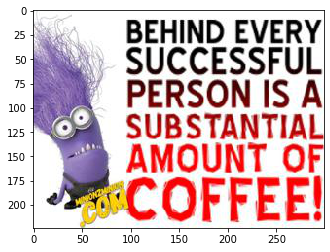

In [0]:
IMG_folder='resized_data'
img=mpimg.imread(os.path.join(IMG_folder,os.listdir(IMG_folder)[6]))
imgplot = plt.imshow(img)

In [0]:
memotion_test=pd.read_csv(os.path.join(data_location,'Memotion_test_p.csv'))
memotion_train=pd.read_csv(os.path.join(data_location,'Memotion_train_p.csv'))
memotion_val=pd.read_csv(os.path.join(data_location,'Memotion_val_p.csv'))

Changing the 'img_name' column to point to the path pointing to the images in the resized_data folder.

In [0]:
memotion_test['img_name']=memotion_test['img_name'].apply(lambda x: os.path.join('resized_data',x))
memotion_train['img_name']=memotion_train['img_name'].apply(lambda x: os.path.join('resized_data',x))
memotion_val['img_name']=memotion_val['img_name'].apply(lambda x: os.path.join('resized_data',x))


In [0]:
memotion_test.head()

,img_name,url,text1,positive_tag
0,resized_data/barney_f_5126eadc91.jpg,https://ct.pimp-my-profile.com/ol/fz/sw/i65/2/...,what do you call,1.0
1,resized_data/titanic_Vd8HSKb.jpg,https://i.imgur.com/Vd8HSKb.jpg,ill give that bitch a necklace love,1.0
2,resized_data/hillary_hillary-turd-meme.jpg,https://thepoliticalinsider.com/files/2016/07/...,g for hillary because she is a woman is like g...,1.0
3,resized_data/zeck_congress-when-they-finally-g...,https://pics.onsizzle.com/congress-when-they-f...,s when they ally get to tion mark zuckerberg i...,1.0
4,resized_data/tech_cb67a56a2f0f09ab2a75891ea15c...,https://www.memeologist.com/wp-content/uploads...,with this technology we will g the united to ...,1.0


In [0]:
memotion_test_f = memotion_test.sample(frac=1).reset_index(drop=True)
memotion_train_f = memotion_train.sample(frac=1).reset_index(drop=True)
memotion_val_f = memotion_val.sample(frac=1).reset_index(drop=True)

In [0]:
memotion_test_f.to_csv('Memotion_test_data.csv')
memotion_train_f.to_csv('Memotion_train_data.csv')
memotion_val_f.to_csv('Memotion_validation_data.csv')

In [0]:
memotion_test_f['positive_tag'].value_counts()

1.0    581
0.0    312
2.0     87
Name: positive_tag, dtype: int64

In [0]:
memotion_train_f['positive_tag'].value_counts()

1.0    2709
0.0    1451
2.0     404
Name: positive_tag, dtype: int64

In [0]:
memotion_val_f['positive_tag'].value_counts()

1.0    580
0.0    310
2.0     86
Name: positive_tag, dtype: int64

In [0]:
memotion_train_f['positive_tag']=memotion_train_f['positive_tag'].astype('float32')
memotion_val_f['positive_tag']=memotion_val_f['positive_tag'].astype('float32')
memotion_test_f['positive_tag']=memotion_test_f['positive_tag'].astype('float32')

As seen, the data that we are using is imbalanced. We did not perform downsampling because that would reduce the size of our dataset by a substantial amount.

To gauge the performance of the model on this unbalanced dataset, we are using weighted- f1 score as a metric.

This sklearn webpage states how weighted f1 accounts for label inbalance while macro- f1 does not

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

## Modeling the data

Baseline models:
1. Image only
2. Text only

In [0]:
base_dir="Memotion_data"
os.mkdir(base_dir)

mem_train_dir = os.path.join(base_dir,'Train')
mem_val_dir = os.path.join(base_dir,'Val')
mem_test_dir = os.path.join(base_dir,'Test')

os.mkdir(mem_train_dir)
os.mkdir(mem_val_dir)
os.mkdir(mem_test_dir)

neutral_train_dir = os.path.join(mem_train_dir,'Neutral')
neutral_val_dir = os.path.join(mem_val_dir,'Neutral')
neutral_test_dir = os.path.join(mem_test_dir,'Neutral')
os.mkdir(neutral_train_dir)
os.mkdir(neutral_val_dir)
os.mkdir(neutral_test_dir)

positive_train_dir = os.path.join(mem_train_dir,'Positive')
positive_val_dir = os.path.join(mem_val_dir,'Positive')
positive_test_dir = os.path.join(mem_test_dir,'Positive')
os.mkdir(positive_train_dir)
os.mkdir(positive_val_dir)
os.mkdir(positive_test_dir)

negative_train_dir = os.path.join(mem_train_dir,'Negative')
negative_val_dir = os.path.join(mem_val_dir,'Negative')
negative_test_dir = os.path.join(mem_test_dir,'Negative')
os.mkdir(negative_train_dir)
os.mkdir(negative_val_dir)
os.mkdir(negative_test_dir)




In [0]:
fnames_neu_tr = memotion_train_f.loc[memotion_train_f['positive_tag']==0,'img_name']
fnames_neu_val = memotion_val_f.loc[memotion_val_f['positive_tag']==0,'img_name']
fnames_neu_te = memotion_test_f.loc[memotion_test_f['positive_tag']==0,'img_name']

fnames_po_tr = memotion_train_f.loc[memotion_train_f['positive_tag']==1,'img_name']
fnames_po_val = memotion_val_f.loc[memotion_val_f['positive_tag']==1,'img_name']
fnames_po_te = memotion_test_f.loc[memotion_test_f['positive_tag']==1,'img_name']

fnames_ne_tr = memotion_train_f.loc[memotion_train_f['positive_tag']==2,'img_name']
fnames_ne_val = memotion_val_f.loc[memotion_val_f['positive_tag']==2,'img_name']
fnames_ne_te = memotion_test_f.loc[memotion_test_f['positive_tag']==2,'img_name']

In [0]:
# Copying training images
for i in fnames_neu_tr:
  dst=os.path.join(neutral_train_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_po_tr:
  dst=os.path.join(positive_train_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_ne_tr:
  dst=os.path.join(negative_train_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

In [0]:
# Copying validation images
for i in fnames_neu_val:
  dst=os.path.join(neutral_val_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_po_val:
  dst=os.path.join(positive_val_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_ne_val:
  dst=os.path.join(negative_val_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

In [0]:
# Copying testing images
for i in fnames_neu_te:
  dst=os.path.join(neutral_test_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_po_te:
  dst=os.path.join(positive_test_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

for i in fnames_ne_te:
  dst=os.path.join(negative_test_dir,i.split('/')[1])
  shutil.copyfile(i,dst)

In [0]:
label_names = sorted(item for item in os.listdir(mem_train_dir))
print(label_names)

['Negative', 'Neutral', 'Positive']


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(mem_train_dir,target_size=(299,299),batch_size=32,class_mode='sparse')
val_generator = val_datagen.flow_from_directory(mem_val_dir,target_size=(299,299), batch_size=32,class_mode='sparse')
test_generator = test_datagen.flow_from_directory(mem_test_dir, target_size=(299,299), batch_size=32,class_mode='sparse',shuffle=False)
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    


Found 4563 images belonging to 3 classes.
Found 976 images belonging to 3 classes.
Found 980 images belonging to 3 classes.
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


## Image + Text

Activation extraction- We are using the weights of the Inception V3 model.

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 8s 0us/step


In [0]:

def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations, image_path

In [0]:
train_path_set = set(memotion_train_f['img_name'])
test_path_set = set(memotion_test_f['img_name'])
valid_path_set = set(memotion_val_f['img_name'])

In [0]:
image_path_set = train_path_set | test_path_set | valid_path_set

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 6519
This make take a few minutes


Extracting activation from images and storing to disk

In [0]:
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

List of text, labels and images for training, validation and test data

In [0]:

memotion_train_f['text1']=memotion_train_f['text1'].astype(str)

text_train = list(memotion_train_f['text1'])
label_train = list(memotion_train_f['positive_tag'])
images_train = list(memotion_train_f['img_name'])



In [0]:
assert len(text_train)==4564
assert len(label_train)==4564
assert len(images_train)==4564

In [0]:

memotion_val_f['text1']=memotion_val_f['text1'].astype(str)

text_val = list(memotion_val_f['text1']) 
label_val = list(memotion_val_f['positive_tag'])
images_val = list(memotion_val_f['img_name'])

In [0]:
assert len(text_val)==976
assert len(label_val)==976
assert len(images_val)==976

In [0]:

memotion_test_f['text1'] = memotion_test_f['text1'].astype(str)

text_test = list(memotion_test_f['text1'])
label_test = list(memotion_test_f['positive_tag'])
images_test = list(memotion_test_f['img_name'])

In [0]:
assert len(text_test)==980
assert len(label_test)==980
assert len(images_test)==980

Create and fit a tokenizer

In [0]:

VOCAB_SIZE = 3000

In [0]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

print("Word index", len(tokenizer.word_index))

Word index 7116


In [0]:

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_val = tokenizer.texts_to_sequences(text_val)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [0]:
length_sequences = [len(i) for i in sequences_train]

In [0]:
from statistics import mode
print(np.mean(length_sequences))
print(np.median(length_sequences))

10.443908851884313
9.0


In [0]:
len(length_sequences)

4564

In [0]:
MAX_SEQ_LEN = 20

In [0]:

padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train,maxlen=MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val,maxlen=MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test,maxlen=MAX_SEQ_LEN)

Converting vectorized text back to string to check if the tokenizer and padding sequences worked fine

In [0]:
train_try = tokenizer.sequences_to_texts(padded_train)
val_try = tokenizer.sequences_to_texts(padded_val)
test_try = tokenizer.sequences_to_texts(padded_test)

In [0]:
train_try[:10]

['me i only listen to real music tom and jerry the hollywood bowl 55k views',
 'mom said',
 'no portia this visit isnt about you',
 'deal with it',
 'collect your purple',
 'i got',
 'so ive never had a girlfriend but i have no exgirlfriends sot got that for me which is nice',
 'a lannister always pays his debts mastercard for everyone else theres mastercard',
 'and suit up tonights g to be legendary',
 'mark zuckerberg is']

In [0]:
val_try[:10]

['there are no gs on me how about we do g about that web at',
 'men are weak g the men g',
 'i got attacked by ist a but i on',
 'i tried to',
 'buys an for with the money he made g your',
 'youre g me i spent e months where',
 'started from the bottom titanic now we here the great',
 'when youve been g pokemon go and have no idea where you are now',
 'pepe 99 9 the frog',
 'sorry i cant today my friends mothers brothers s fish died and it was']

In [0]:
test_try[:10]

['for the last time peter im not hitler stop g for',
 'hey girl do u like ice',
 'mark zuckerberg is g away 40 star at midnight just share this picture and',
 'dear lord baby us thank you for my hot girlfriend',
 'nan',
 'the',
 'when ur at work and a customer starts g at u but u cant do g because the always right',
 'i hate i hate i wish and would stop g ravenclaw everyone im g',
 'i k weekends are a they dont last long',
 'donald trump by the time he is done with his four year idency']

Creating tf.data for train,validation and split

In [0]:

BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:

def load_np(img_path, question, answer):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, question, answer, img_path

In [0]:

def create_dataset(images, sequences, answers):
  dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                sequences, 
                                                answers))
  
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.int32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [0]:

train_ds = create_dataset(images_train, padded_train, label_train)
val_ds = create_dataset(images_val, padded_val, label_val)
test_ds = create_dataset(images_test, padded_test, label_test )

In [0]:
print(type(padded_train[0]))
print(type(images_train[0]))
print(type(label_train[0]))

<class 'numpy.ndarray'>
<class 'str'>
<class 'float'>


In [0]:

my_iterator = iter(train_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
       questions_batch.shape, 
       answers_batch.shape, 
       paths_batch.shape)


(32, 8, 8, 2048) (32, 20) (32,) (32,)


In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, Dropout,GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Model, Sequential


In [0]:

GLOVE_DIR=os.path.join('drive','My Drive')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector
word_index= tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=20,
                            trainable=False)

In [0]:
#GLOVE with dropout

image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 


question_input = Input(shape=(20,), dtype='int32')
embedded_question = embedding_layer(question_input)
#dropout_layer = Dropout(0.5)(embedded_question)
encoded_question = LSTM(64)(embedded_question)
#encoded_question = LSTM(64)(dropout_layer)

# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

dense = Dense(128, activation='relu')(merged)


# Next, adding a classifier on top
output = Dense(3, activation='softmax')(dense)

# Your final model
model_glove = Model(inputs=[image_input, question_input], outputs=output)

In [0]:

model_glove.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model_glove.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 300)      2135100     input_25[0][0]                   
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 2048)         0           input_24[0][0]                   
___________________________________________________________________________________________

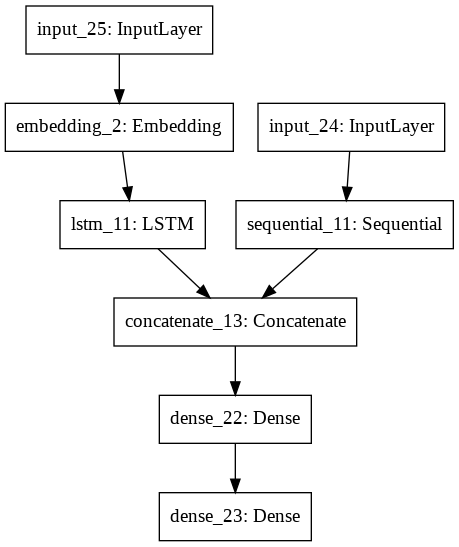

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_glove, to_file='model0.png')

In [0]:
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

In [0]:

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:

def evaluate_glove(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model_glove.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [0]:

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 

for epoch in range(epochs):

  start = time.time()

  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model_glove.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    train_loss(result[0])
    train_accuracy(result[1])

  evaluate_glove(max_steps=100)

  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()


Epoch 0, Loss: 0.93, Accuracy: 57.05, Val Loss 0.89, Val Accuracy 59.43, Time: 7.9 secs
Epoch 1, Loss: 0.89, Accuracy: 59.26, Val Loss 0.89, Val Accuracy 59.43, Time: 5.8 secs
Epoch 2, Loss: 0.87, Accuracy: 59.22, Val Loss 0.90, Val Accuracy 59.43, Time: 5.8 secs
Epoch 3, Loss: 0.85, Accuracy: 59.64, Val Loss 0.94, Val Accuracy 59.43, Time: 6.3 secs
Epoch 4, Loss: 0.81, Accuracy: 61.54, Val Loss 0.94, Val Accuracy 54.20, Time: 5.8 secs
Epoch 5, Loss: 0.76, Accuracy: 64.69, Val Loss 0.98, Val Accuracy 58.50, Time: 5.8 secs
Epoch 6, Loss: 0.69, Accuracy: 68.16, Val Loss 1.04, Val Accuracy 57.79, Time: 5.9 secs
Epoch 7, Loss: 0.61, Accuracy: 73.42, Val Loss 1.11, Val Accuracy 53.07, Time: 5.8 secs
Epoch 8, Loss: 0.48, Accuracy: 80.83, Val Loss 1.22, Val Accuracy 52.56, Time: 5.9 secs
Epoch 9, Loss: 0.38, Accuracy: 85.48, Val Loss 1.39, Val Accuracy 52.77, Time: 5.8 secs


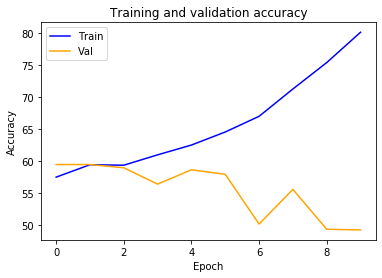

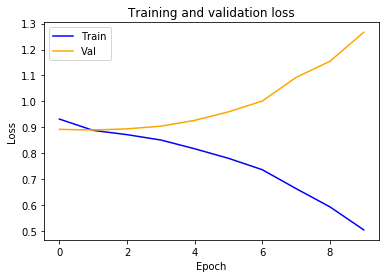

In [0]:

epochs = range(len(val_acc_history))

plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc_history, color='blue', label='Train')
plt.plot(epochs, val_acc_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, train_loss_history, color='blue', label='Train')
plt.plot(epochs, val_loss_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [0]:

predictions_final=[]
def evaluate_test(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    predictions = model_glove.predict(x=[activation_batch, question_batch])
    #print(type(predictions))
    predictions_final.append(predictions)


In [0]:
evaluate_test()

In [0]:
preds=[np.argmax(y) for x in predictions_final for y in x]

In [0]:

print(precision_recall_fscore_support(label_test, preds, average='macro'))
print(precision_recall_fscore_support(label_test, preds, average='weighted'))

(0.3162752772341813, 0.3137527373609634, 0.3088116844430684, None)
(0.4359672910259994, 0.46938775510204084, 0.4497718632943044, None)


Without using glove embedding

In [0]:

image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 


question_input = Input(shape=(20,), dtype='int32')
embedded_question = Embedding(input_dim=3000, output_dim=32, input_length=20)(question_input)
dropout_layer = Dropout(0.5)(embedded_question)
encoded_question = LSTM(32)(embedded_question)
#encoded_question = LSTM(32)(dropout_layer)


merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

dense = Dense(64, activation='relu')(merged)


# Next, adding a classifier on top
output = Dense(3, activation='softmax')(dense)

# Your final model
model = Model(inputs=[image_input, question_input], outputs=output)

In [0]:

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 32)       96000       input_19[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 2048)         0           input_18[0][0]                   
____________________________________________________________________________________________

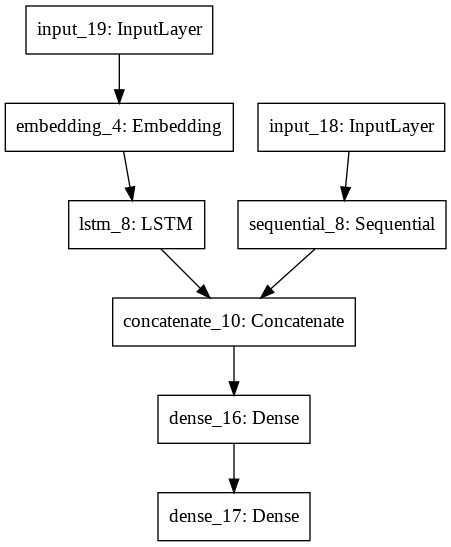

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model1.png')

In [0]:
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

In [0]:

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:
# You should not need to modify this.
def evaluate_1(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [0]:

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 

for epoch in range(epochs):

  start = time.time()

  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    train_loss(result[0])
    train_accuracy(result[1])

  evaluate_1(max_steps=100)

  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()


Epoch 0, Loss: 0.94, Accuracy: 56.75, Val Loss 0.91, Val Accuracy 59.43, Time: 8.0 secs
Epoch 1, Loss: 0.89, Accuracy: 58.50, Val Loss 0.90, Val Accuracy 59.12, Time: 6.2 secs
Epoch 2, Loss: 0.81, Accuracy: 64.39, Val Loss 0.97, Val Accuracy 50.72, Time: 6.1 secs
Epoch 3, Loss: 0.72, Accuracy: 69.91, Val Loss 1.01, Val Accuracy 52.25, Time: 5.9 secs
Epoch 4, Loss: 0.62, Accuracy: 75.26, Val Loss 1.10, Val Accuracy 54.10, Time: 6.1 secs
Epoch 5, Loss: 0.54, Accuracy: 78.79, Val Loss 1.22, Val Accuracy 54.51, Time: 6.3 secs
Epoch 6, Loss: 0.49, Accuracy: 81.01, Val Loss 1.37, Val Accuracy 53.38, Time: 6.1 secs
Epoch 7, Loss: 0.43, Accuracy: 83.26, Val Loss 1.38, Val Accuracy 50.61, Time: 6.0 secs
Epoch 8, Loss: 0.39, Accuracy: 84.48, Val Loss 1.59, Val Accuracy 54.20, Time: 5.9 secs
Epoch 9, Loss: 0.35, Accuracy: 86.24, Val Loss 1.72, Val Accuracy 49.69, Time: 5.9 secs


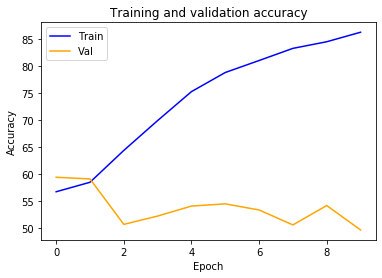

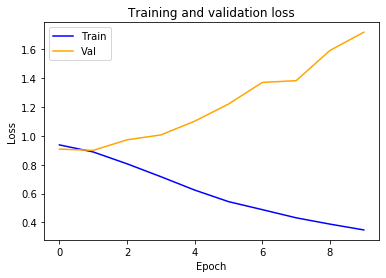

In [0]:
epochs = range(len(val_acc_history))

plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc_history, color='blue', label='Train')
plt.plot(epochs, val_acc_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, train_loss_history, color='blue', label='Train')
plt.plot(epochs, val_loss_history, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Predicting on test set

In [0]:

predictions_final=[]
def evaluate_test(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    predictions = model.predict(x=[activation_batch, question_batch])
    #print(type(predictions))
    predictions_final.append(predictions)


In [0]:
evaluate_test()

In [0]:
# 31 batches - with 30 batches of size 32 and one of size 30
assert len(predictions_final)==31

In [0]:
preds=[np.argmax(y) for x in predictions_final for y in x]

In [0]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(label_test, preds, average='macro'))
print(precision_recall_fscore_support(label_test, preds, average='weighted'))

(0.33079448479900636, 0.3300416520192175, 0.3295965449284996, None)
(0.47081490072322074, 0.4806122448979592, 0.47475655738811195, None)


In [0]:
correct_preds=[]
incorrect_preds=[]
for i in range(len(label_test)):
  if label_test[i]==preds[i]:
    correct_preds.append(i)
  else:
    incorrect_preds.append(i)

In [0]:
len(correct_preds)

471

In [0]:
len(incorrect_preds)

509

We found that the training accuracy for the model without glove embedding is better than the one which uses glove embedding.

To achieve a high training accuracy in the glove model with validation accuracy comparable to the one without glove, we had to use a denser model with larger number of parameters.

Observing this trend and the weighted f1 scores, we reached the conclusion that using a model without glove embedding is better than incorporating glove embedding in the model.

Our assumption regarding why glove embedding isn't performing well is because the meme text consists of a lot more slang words as compared to regular english words, glove embedding won't assign weights to most of the words in the meme text and hence it performs worse.

Next, we are showing 2 correct and 2 incorrect predictions
performed by our best model (the one without glove embeddings).

Correct Predictions

Meme text:  even i am afraid of the gs my 
Prediction: Neutral
Actual: Neutral


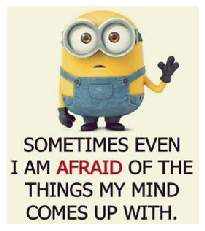

In [0]:
my_dict={0:'Neutral',1:'Positive',2:'Negative'}
i=correct_preds[24]
img=plt.imread(images_test[i])
img_final = tf.image.resize(img, [299,299])
print('Meme text:',text_test[i])
print("Prediction:", my_dict[int(preds[i])])
print("Actual:", my_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

Meme text: leave the gun take the cheerios mc 
Prediction: Positive
Actual: Positive


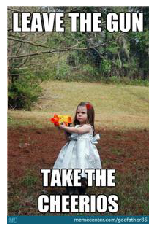

In [0]:
my_dict={0:'Neutral',1:'Positive',2:'Negative'}
i=correct_preds[64]
img=plt.imread(images_test[i])
img_final = tf.image.resize(img, [299,299])
print('Meme text:',text_test[i])
print("Prediction:", my_dict[int(preds[i])])
print("Actual:", my_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

Incorrect predictions

Meme text: when your friend ally  a show you kept g them about and they love it 
Prediction: Negative
Actual: Positive


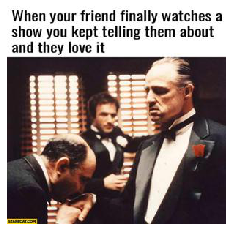

In [0]:
my_dict={0:'Neutral',1:'Positive',2:'Negative'}
i=incorrect_preds[10]
img=plt.imread(images_test[i])
img_final = tf.image.resize(img, [299,299])
print('Meme text:',text_test[i])
print("Prediction:", my_dict[int(preds[i])])
print("Actual:", my_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)

Meme text: buys iphone 
Prediction: Positive
Actual: Neutral


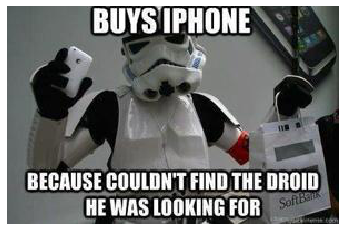

In [0]:
my_dict={0:'Neutral',1:'Positive',2:'Negative'}
i=incorrect_preds[11]
img=plt.imread(images_test[i])
img_final = tf.image.resize(img, [299,299])
print('Meme text:',text_test[i])
print("Prediction:", my_dict[int(preds[i])])
print("Actual:", my_dict[int(label_test[i])])
plt.axis('off')
_=plt.imshow(img)